<h1 align='center'>Домашнее задание</h1>

**Дополнительный материал для выполнения дз**:

- Лекция Coursera: https://ru.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression
- Статья на Хабре: https://habrahabr.ru/company/io/blog/265007/
- Книжка ISLR, 4 глава: http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf
- Логистическая регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/
- Линейная регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LinearRegression/


<h1 align='center'>Logistic Regression</h1>

In [1]:
import pandas as pd
import numpy as np
import tqdm # interactive progress bar

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Знакомство с данными
Данные представляют собой выборку отзывов о еде с сайта Амазон. Для них проставлены метки -- положительный или отрицательный отзыв.

In [2]:
train_df = pd.read_csv('./data/train.csv')

In [3]:
print(train_df.shape)

(110163, 3)


In [4]:
train_df.Prediction.value_counts(normalize=True)

0    0.50074
1    0.49926
Name: Prediction, dtype: float64

Видим, что классы сбалансированы. Можем оценивать качество модели по метрике ```accuracy```.

In [5]:
train_df.head()

,ID,Reviews_Summary,Prediction
0,239071,Michigan Cherries,1
1,466160,Great Product,1
2,397133,Ovaltine,1
3,297146,~,1
4,292685,Love it!,1


In [6]:
train_df.tail()

,ID,Reviews_Summary,Prediction
110158,486256,Terrible!,0
110159,199050,"Cheap Coffee, No Banana Flavor",0
110160,278179,Not as described,0
110161,87500,Tastes like a squirt of toothpaste mixed into ...,0
110162,121963,Disappointed,0



----------
## 2. Извлечение признаков
Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координате равно количеству раз, слово используется в документе. 

Для решения данной задачи напишем код, который преобразовывает матрицу документов в численную матрицу.

Дополнительная информация:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Разряженные матрицы: http://www.scipy-lectures.org/advanced/scipy_sparse/
- Трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Помните, что все эти трансформеры возвращают ```sparse```-матрицы. Учитывая это и то, что линейные модели достаточно хорошо масштабируются на большое количество фич, можно смело ставить ```n_features``` 1000+.

In [7]:
review_summaries = list(train_df['Reviews_Summary'].values)
review_summaries = [l.lower() for l in review_summaries]

In [8]:
review_summaries[:5]

['michigan cherries', 'great product', 'ovaltine', '~', 'love it!']

Преобразуем ```review_summaries``` с помощью ```TfidfVectorizer```.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
vectorizer = TfidfVectorizer()

In [11]:
tfidfed = vectorizer.fit_transform(review_summaries)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = tfidfed
y = train_df.Prediction.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## 3. Логистическая регрессия

Логистическая регрессия -- линейный классификатор, который очень часто используется на практике, например, в кредитном скоринге. Преимущества этой модели -- скорость обучения и предсказания (даже при сотнях тысяч фичей) а также интепретируемость: важные признаки имеют бОльшие по модулю веса. 

При этом отрицательные веса говорят, что фича важна для определения класса 0, а положительные -- для определения класса 1. Это можно понять, если вспомнить, что разделяющая поверхность линейных моделей, это $w^Tx = 0$, а значение алгоритма есть $a(x) = sign(w^Tx)$.

Будем предсказывать сентимент, подготовим данные и сделаем валидационную выборку. При этом нужно оценивать качество модели не по обучающей выборке, а по валидационной. Иначе вы переобучитесь, когда будете тюнить гиперпараметры модели.

-----
** Реализуйте код в модуле ```dmia.classifiers.logistic_regression```.**

-----

In [14]:
from dmia.gradient_check import *
from dmia.classifiers.logistic_regression import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Gradient check

В этой ячейке вы можете проверить, правильно ли у вас все работает, прежде чем обучать модель на всех данных.

In [15]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]
clf = LogisticRegression()
clf.w = np.random.randn(X_train_sample.shape[1]+1) * 2
loss, grad = clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, clf.w, grad, 10)

numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.000051 analytic: -0.000051, relative error: 5.663452e-09
numerical: -0.000071 analytic: -0.000071, relative error: 7.239061e-08
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.000002 analytic: -0.000002, relative error: 1.491997e-06
numerical: 0.000000 analytic: 0.000000, relative error: nan


/Users/aleksandrevgrafov/PycharmProjects/otus_python/logistic_regression/dmia/gradient_check.py:50: RuntimeWarning: invalid value encountered in double_scalars
  rel_error = abs(grad_numerical - grad_analytic) / (


Обучите свою модель на ```X_train, y_train```.

Для начала можете взять параметры по умолчанию, и найти оптимальные используя валидацию.

In [16]:
clf = LogisticRegression()

In [17]:
clf.train(X_train, y_train)

Посмотрим на качество на валидации.

In [18]:
print("Train f1-score = %.3f" % accuracy_score(y_train, clf.predict(X_train)))
print("Test f1-score = %.3f" % accuracy_score(y_test, clf.predict(X_test)))

Train f1-score = 0.505
Test f1-score = 0.509


Нарисуем кривые обучения.

In [19]:
clf = LogisticRegression()
train_scores = []
test_scores = []
num_iters = 1000

for i in tqdm.trange(num_iters):
    # Сделайте один шаг градиентного спуска с помощью num_iters=1
    clf.train(X_train, y_train, learning_rate=1.0, num_iters=1, batch_size=256, reg=1e-3)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.48it/s]


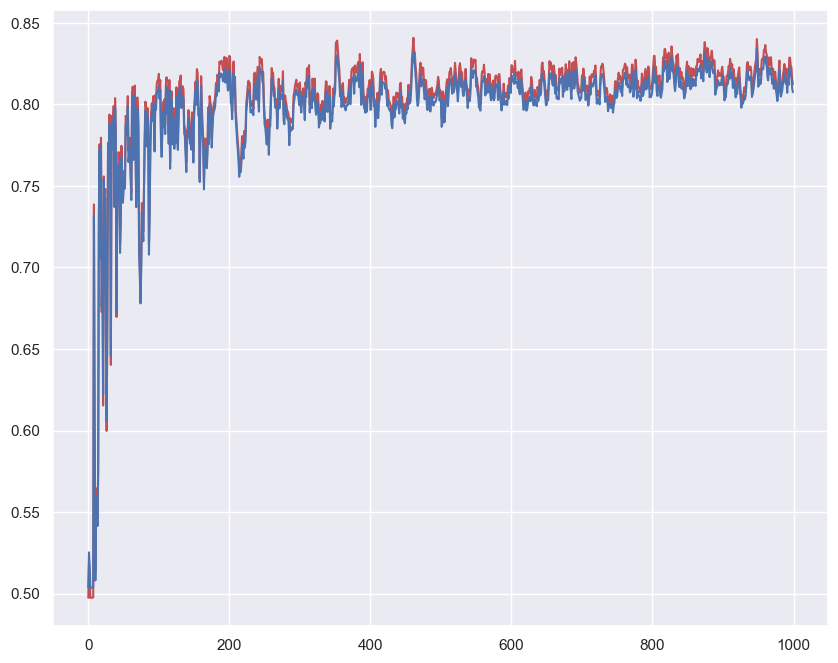

In [20]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

## 4. Задание

* Обучим нашу модель **на всех данных**, преобразовав их через ```TfidfVectorizer``` с ```max_features=3000```.

* Параметры модели ```learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3``` и выведем первые 5 самых важных фичей для класса 1 и 5 фичей для класса 0. Убедимся, что они коррелируют с вашей интуицией о хороших/плохих отзывах. 

**Hint:** зная индекс фичи, само слово вы можете получить, используя метод ```vectorizer.get_feature_names()```.

**Hint:** ```np.argsort```.

In [21]:
# Обучите модель
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(review_summaries)
y = train_df.Prediction.values
clf = LogisticRegression()
clf.train(X, y, verbose=True, learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3)

iteration 0 / 1000: loss 0.694348
iteration 100 / 1000: loss 0.630194
iteration 200 / 1000: loss 0.593204
iteration 300 / 1000: loss 0.589192
iteration 400 / 1000: loss 0.582503
iteration 500 / 1000: loss 0.570133
iteration 600 / 1000: loss 0.560740
iteration 700 / 1000: loss 0.582499
iteration 800 / 1000: loss 0.610908
iteration 900 / 1000: loss 0.579330


In [22]:
# Получите индексы фичей
pos_features = np.argsort(clf.w)[-5:]
neg_features = np.argsort(clf.w)[:5]

In [23]:
# Выведите слова
fnames = vectorizer.get_feature_names()
print([fnames[p] for p in pos_features])
print([fnames[n] for n in neg_features])

['excellent', 'delicious', 'love', 'best', 'great']
['not', 'disappointed', 'bad', 'too', 'horrible']


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 5. Сравнение с sklearn.linear_model.LogisticRegression

Обучите такую же модель, но из пакета ```sklearn.linear_model``` и убедитесь, что ваша имплементация ничем не хуже (ну или почти не хуже).

In [24]:
from sklearn import linear_model

In [25]:
clf = linear_model.SGDClassifier(max_iter=1000, random_state=42, loss="log_loss", penalty="l2", alpha=1e-3, eta0=1.0, learning_rate="constant")
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.001, eta0=1.0, learning_rate='constant', loss='log_loss',
              random_state=42)

In [26]:
print("Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test)))

Train accuracy = 0.816
Test accuracy = 0.812
